<a href="https://colab.research.google.com/github/cavannus/ttow-ML/blob/main/wayang_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile

local_zip = '/content/wayang.zip'
# local_zip = '/content/wayang-talha.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
base_dir = '/content/images/'
# base_dir = '/content/wayang/images/'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [ ]:
IMG_SIZE = (175, 225)
IMG_SHAPE = IMG_SIZE + (3,)

In [ ]:
import tensorflow as tf

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 175, 225, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 88, 113, 32)  864         input_8[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 88, 113, 32)  128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 88, 113, 32)  0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
inputs = tf.keras.Input(shape=(175, 225, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.4)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 175, 225, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 6, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   horizontal_flip = True,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   fill_mode = 'nearest',
                                   shear_range = 0.5,
                                   rotation_range=60,
                                   zoom_range=0.4,
                                   )
test_datagen  = ImageDataGenerator(rescale = 1.0/255,)

# --------------------
# Flow training images in batches of 15 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=24,
                                                    class_mode='categorical',
                                                    target_size=(175, 225))     
# --------------------
# Flow validation images in batches of 15 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=15,
                                                         class_mode='categorical',
                                                         target_size=(175, 225))


Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [ ]:
class Acc_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if logs['accuracy'] > 0.98:
      print('\nAccuracy is more than 98%')
      self.model.stop_training = True

callbacks = Acc_Callback()

In [ ]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=24,
                    epochs=90,
                    validation_steps=8,
                    verbose=2,
                    callbacks=[callbacks])

Epoch 1/90
24/24 - 21s - loss: 0.9380 - accuracy: 0.6146 - val_loss: 0.5206 - val_accuracy: 0.8083
Epoch 2/90
24/24 - 21s - loss: 0.9050 - accuracy: 0.6128 - val_loss: 0.5210 - val_accuracy: 0.8417
Epoch 3/90
24/24 - 21s - loss: 0.9375 - accuracy: 0.5833 - val_loss: 0.5166 - val_accuracy: 0.8417
Epoch 4/90
24/24 - 21s - loss: 0.9553 - accuracy: 0.5764 - val_loss: 0.5107 - val_accuracy: 0.8417
Epoch 5/90
24/24 - 21s - loss: 0.8722 - accuracy: 0.6458 - val_loss: 0.4976 - val_accuracy: 0.8417
Epoch 6/90
24/24 - 21s - loss: 0.8990 - accuracy: 0.6094 - val_loss: 0.4957 - val_accuracy: 0.8083
Epoch 7/90
24/24 - 21s - loss: 0.9022 - accuracy: 0.6128 - val_loss: 0.4933 - val_accuracy: 0.8417
Epoch 8/90
24/24 - 21s - loss: 0.9228 - accuracy: 0.6198 - val_loss: 0.4871 - val_accuracy: 0.8417
Epoch 9/90
24/24 - 21s - loss: 0.8421 - accuracy: 0.6250 - val_loss: 0.4741 - val_accuracy: 0.8417
Epoch 10/90
24/24 - 21s - loss: 0.8743 - accuracy: 0.6250 - val_loss: 0.4749 - val_accuracy: 0.8417
Epoch 11/

Text(0.5, 1.0, 'Training and validation loss')

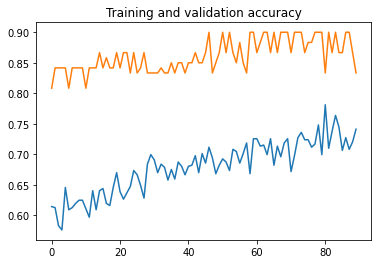

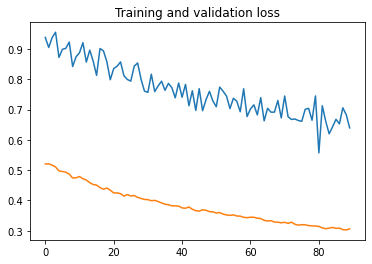

In [ ]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  
  path='/content/' + fn
  img=image.load_img(path, target_size=(175, 225))
  
  x=image.img_to_array(img)
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes = model.predict(images, batch_size=10)
  
  print(classes)

KeyboardInterrupt: ignored